## DFA-RAG CODE IMPLEMENTATION 🔥 
#### Conversational Semantic Router for Large Language Model with Definite Finite Automaton
##### WILTON BELTRE

In [1]:
import json 
from typing import List, Dict, Set

with open('synth_data/synth_conversations_llama_round_1_with_tags.json', "r") as synth:
    conversations = json.load(synth)


In [2]:
import re
from collections import Counter


def most_frequent_tag(S: List[Set[str]]) -> str:
    flat_list = [element for sublist in S for element in sublist]
    counter = Counter(flat_list)
    most_common = counter.most_common(1)
    return most_common[0]


def interception(t: str, S: List[Set[str]]) -> List[Set[str]]:
    S_i = [s for s in S if t in s]
    return [{i for i in s if t not in i } for s in S_i]
    

def complement(t: str, S: List[Set[str]]) -> List[Set[str]]:
    return [s for s in S if t not in s]


def collect_tags(conversations: List, C: int = -1) -> List:
    C = len(conversations) if C == -1 else C
    collect_round = [[] for _ in range(max([len(c) for c in conversations[:C]]))]

    for round in range(len(collect_round)):
        tags_list = []
        for cID in range(len(conversations[:C])):
            try:
                tags = conversations[cID][round]['tags'].split()
                tags_list.append(set(tags))
            except Exception as ex: pass
        collect_round[round] = tags_list

    def is_hashtag(s) -> bool:
        """Return True if the input string is a hashtag, False if it's a word"""
        return bool(re.match(r'\A#(?:[-\w]+)\Z', s))

    # clean not-hashtags
    collect_round = [[{e for e in elems if is_hashtag(e)} for elems in tag]  for tag in collect_round]

    return collect_round


tags = collect_tags(conversations)


In [3]:
import os
os.environ["PATH"] = os.environ["PATH"] + ":/opt/local/bin"
import json
from typing import List, Optional, Any, Generator
from graphviz import Digraph
from transitions import Machine


class TagNode:
    def __init__(self, name: str, dfa: 'DFA') -> None:
        self.name: str = name
        self.children: DFA = dfa


class DFA:
    def __init__(self, sequence: int, round: int = 0,  is_final: bool = False) -> None:
        self.state = f"state_{sequence}" if not is_final else "final"
        self.round = round
        self.terminal = True
        self.is_final = is_final
        self.tags: List[TagNode] = []
        self.parent: 'DFA' = None
        
    def add_transition(self, tag: str, child_dfa: 'DFA') -> None:
        self.terminal = False
        child_dfa.parent = self
        self.tags.append(TagNode(name=tag, dfa=child_dfa))

    def dfa_to_dict(self) -> Dict[str, Any]:
        def _convert(dfa: DFA) -> Dict[str, Any]:
            return {
                'state': dfa.state,
                'final': dfa.is_final,
                'tags': [
                    {
                        'name': tag.name,
                        'child': _convert(tag.children)
                    } for tag in dfa.tags
                ]
            }
        return _convert(self)    
    
    def dfa_to_graph(self, dfa: 'DFA', graph=None, parent=None, added_nodes=None, added_edges=None) -> Digraph:
        if graph is None:
            graph = Digraph()
            graph.attr(rankdir='LR')
            graph.attr('node', shape='circle')
            added_nodes = set()
            added_edges = set()
            
        # Add the current state to the graph if it hasn't been added yet
        if dfa.state not in added_nodes:
            if dfa.is_final:
                graph.node(dfa.state, shape='doublecircle')
            else:
                graph.node(dfa.state, shape='circle')
            added_nodes.add(dfa.state)
        
        if parent:
            edge = (parent, dfa.state)
            if edge in added_edges:
                graph.edge(parent, dfa.state)
                added_edges.add(edge)
        
        # Recursively add the children
        for tag in dfa.tags:
            child_edge = (dfa.state, tag.children.state, tag.name)
            if child_edge not in added_edges:
                graph.edge(dfa.state, tag.children.state, label=tag.name)
                added_edges.add(child_edge)
            dfa.dfa_to_graph(tag.children, graph, dfa.state, added_nodes, added_edges)
        
        return graph


    def traverse_dfa(self) -> Generator['DFA', None, None]:
        """
        Traverse the DFA from the root to the leaves, yielding each state.

        :param dfa: The DFA to traverse.
        :yield: Each DFA state.
        """
        def _traverse(dfa: DFA) -> Generator[DFA, None, None]:
            yield dfa
            for tag in dfa.tags:
                yield from _traverse(tag.children)
        
        yield from _traverse(self)


    def _delete_child(self, dfa: 'DFA', state: str) -> bool:
        """
        Delete a child DFA by its state name.
        
        :param dfa: The root DFA to start searching from.
        :param state: The state name of the child DFA to delete.
        :return: True if the child was found and deleted, False otherwise.
        """
        for tag in dfa.tags:
            if tag.children.state == state:
                dfa.tags.remove(tag)
                # Update the terminal attribute if there are no more children
                if not dfa.tags:
                    dfa.terminal = True
                return True
            if self._delete_child(tag.children, state):
                return True
        return False


    def prune(self, sequence: int) -> None:
        final_state = DFA(sequence=sequence, is_final=True)
        final_state.terminal = False
        for q in self.traverse_dfa():
            if q.terminal:
                t = q.parent.tags[0] # has only ONE tag
                q.parent.add_transition(tag=t.name, child_dfa=final_state)
                self._delete_child(self, state=q.state)




In [16]:
paper_conversations = [
    [
        {'speaker': 'user', 'message': "My iPhone battery drain fast", 'tags': '#keyboard #issue'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#link'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#thank'},
    ],
    [
        {'speaker': 'user', 'message': "My iPhone battery drain fast", 'tags': '#battery #issue'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#link'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#thank'},
    ],
    [
        {'speaker': 'user', 'message': "My iPhone battery drain fast", 'tags': '#update'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#link'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#thank'},
    ],
    [
        {'speaker': 'user', 'message': "My iPhone battery drain fast", 'tags': '#issue'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#link'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#thank'},
        {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#bye'},
    ],
    # [
    #     {'speaker': 'user', 'message': "My iPhone battery drain fast", 'tags': '#issue #screen #pick'},
    #     {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#form'},
    #     {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#thank'},
    #     {'speaker': 'user', 'message': "Thanks. Will be back soon.", 'tags': '#bye'},
    # ]
]


states added 12: : 14it [00:00, 2578.28it/s]


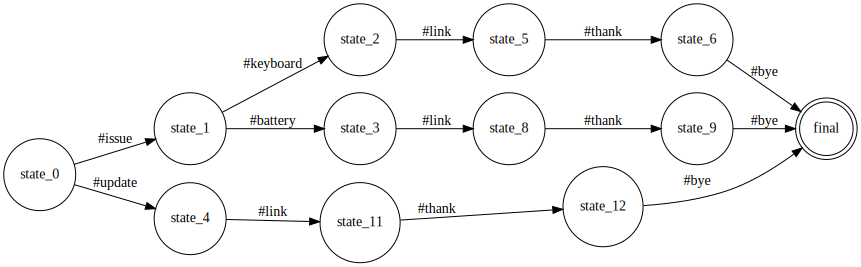

In [17]:
from typing import List, Set
from tqdm import tqdm


class Seq:
    _sequence = 0
    _state = 0
    @classmethod
    def next(cls):
        seq = cls._sequence
        cls._sequence += 1
        return seq
    
    @classmethod
    def next_state(cls):
        seq = cls._state
        cls._state += 1
        return seq

def build(q: DFA, S: List[Set[str]], round: int, progress):
    if len(S) == 0:
        return
    elif len(S[0]) == 0:
        return
    
    progress.set_description(f"states added {Seq.next_state()}")

    tag = most_frequent_tag(S)

    q_= DFA(sequence=Seq.next(), round=round)
    q.add_transition(tag=tag[0], child_dfa=q_)

    S_i = interception(tag[0], S)
    S_c = complement(tag[0], S)
    build(q_, S_i, round, progress)
    build(q, S_c, round, progress)


def main(tags: List) -> DFA:
    dfa_root = DFA(sequence=Seq.next())
    progress = tqdm(dfa_root.traverse_dfa(), ncols=110)
    for q in progress:
        if q.terminal and q.round < len(tags):
            S = tags[q.round]
            build(q, S, q.round + 1, progress)
    
    return dfa_root


tags = collect_tags(conversations=conversations[20:22])
paper_tags = collect_tags(conversations=paper_conversations)

# tags = [
#     [
#         {'#interest'},
#         {'#introduction'},
#         {'#introduction'},
#         {'#position', '#followup'},
       
#     ],
#     [
#         {'#application', '#form'},
#         {'#basic', '#form'},
#         {'#introduction', '#form'},
#         {'#introduction'},
       
#     ],
#     [
#         {'#form', '#completed'},
#         {'#form_completed'},
#         {'#form', '#completed'},
#         {'#greeting'},
        
#     ],
#     [
#         {'#form', '#completed'},
#         {'#form', '#completed'},
#         {'#form', '#completed'},
#         {'#basic', '#form'},
        
#     ],
# ]

dfa_root = main(tags=paper_tags)

dfa_root.prune(sequence=Seq.next())


from rich import print

sample = dfa_root.dfa_to_dict()
with open("sample.json", "w") as raw:
    json.dump(sample, raw, indent=4)
# print(tags)

d = dfa_root.dfa_to_graph(dfa=dfa_root)
d
